# Target Market Analysis

In [10]:
import sys
from importlib import reload

sys.path.append('/Users/bichengwang/Documents/codes/python-notebook/src')
reload(sys)

from lib.cash_flow_tools import generate_cash_flow

import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.propagate = True

cash_flow, pv, fv = generate_cash_flow(
    initial=1000., 
    annual_investment=120., 
    years=30, 
    annual_growth_rate=0.05, 
    annual_risk_free_rate=0.05, 
    mode='monthly')

INFO:lib.cash_flow_tools:{'pv': 4590.0, 'fv': 20421.855337382258}


In [11]:
import pandas as pd
import numpy as np
from tabulate import tabulate

def tabulate_printer(dic):
    return "\n{}".format(tabulate(
        [[k,v] for k, v in dic.items()], 
        headers=['Key', 'Value'], tablefmt='grid'))

def loader(ticker='SPX'):
    return pd.read_csv('/Users/bichengwang/Documents/codes/python-notebook/data/finance/{} GOOGLEFINANCE.csv'.format(ticker.upper()))

df = loader()
# Now df contains your data with the 'date' column parsed as datetime objects
df.head()

,Date,Close
0,1/2/1970 16:00:00,93.00
1,1/9/1970 16:00:00,92.40
2,1/16/1970 16:00:00,90.92
3,1/23/1970 16:00:00,89.37
4,1/30/1970 16:00:00,85.02


## Investment Analysis

In [12]:
def buy_and_sell(df, annual_risk_free_rate=0.06, span=4):
    # span lookback weeks
    # risk free rate
    df['Moving_Average'] = df['Close'].rolling(window=span).mean()
    df['EMA'] = df['Close'].ewm(span=span, adjust=False).mean()
    df['Mark'] = df['Close'] > df['EMA']
    marks = df['Mark'].values
    curr = marks[0]
    prices = df['Close'].values
    spx_returns = (df['Close'] / prices[0]).values
    base = 1.
    share = 0.
    security_returns = []
    strategy = []
    ### buy in strategy
    for mark, price in zip(marks, prices):
        if mark != curr:
            if not mark:
                share += base / price
                base = 0.
                strategy.append('Buy')
            else:
                base += share * price
                share = 0.
                strategy.append('Sell')
        else:
            strategy.append('Hold')
        curr = mark
        security_returns.append(base + share * price)
    ratio = (base + share * prices[-1]) / (prices[-1] / prices[0])

    # Calculate the mean returns
    security_mean_return = np.mean(security_returns)
    spx_mean_return = np.mean(spx_returns)

    # Calculate the covariance and variance of returns
    covariance = np.cov(security_returns, spx_returns)[0, 1]
    variance_spx = np.var(spx_returns)

    # Calculate beta
    beta = covariance / variance_spx

    # Calculate alpha
    alpha = security_mean_return - (beta * spx_mean_return)

    # Calculate the excess return of the security over the risk-free rate
    # Sample weekly returns of the security and risk-free rate
    annual_security_returns =  np.array([y/x for x, y in zip(security_returns[:-52], security_returns[52:])])

    # Calculate the excess return of the security over the risk-free rate
    excess_returns = annual_security_returns - annual_risk_free_rate

    # Calculate the annualized average excess return
    annualized_excess_return = np.mean(excess_returns)  # Approximate number of weeks in a year

    # Calculate the annualized standard deviation of returns
    annualized_std_dev = np.std(annual_security_returns) # Approximate number of weeks in a year

    # Calculate the annual Sharpe Ratio
    annual_sharpe_ratio = annualized_excess_return / annualized_std_dev

    def calculate_maximum_withdrawal_rate(weekly_returns, target_years, tolerance=1e-6):
        withdrawal_rate = 0.01  # Starting withdrawal rate
        while True:
            # Calculate portfolio balance after target_years with current withdrawal rate
            balance = calculate_portfolio_balance(weekly_returns, withdrawal_rate)
            if balance > 0:  # If portfolio lasts for target_years, reduce withdrawal rate
                withdrawal_rate += tolerance
            else:  # If portfolio doesn't last, return previous withdrawal rate
                return withdrawal_rate - tolerance

    return {
        'ratio':ratio, 
        'origin':(prices[-1]/prices[0]), 
        'value':security_returns[-1],
        'beta': beta, 
        'alpha': alpha,
        'annual_sharp_ratio': annual_sharpe_ratio,
        'latest_recommand': strategy[-10:]
    }

print(df.tail(5))
print(buy_and_sell(df.iloc[5:]))

                    Date    Close
2834  3/28/2024 16:00:00  5254.35
2835   4/5/2024 16:00:00  5204.34
2836  4/12/2024 16:00:00  5123.41
2837  4/19/2024 16:00:00  4967.23
2838  4/26/2024 16:00:00  5099.96
{'ratio': 0.14865393862747855, 'origin': 59.07517664774702, 'value': 8.78175768380164, 'beta': 0.15747043055171364, 'alpha': 0.9926092731088643, 'annual_sharp_ratio': 9.137819846789585, 'latest_recommand': ['Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Buy', 'Hold', 'Sell']}


/var/folders/ls/5qzq87350jz6pv6jwnpg6mkm0000gn/T/ipykernel_48720/3534036788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Moving_Average'] = df['Close'].rolling(window=span).mean()
/var/folders/ls/5qzq87350jz6pv6jwnpg6mkm0000gn/T/ipykernel_48720/3534036788.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EMA'] = df['Close'].ewm(span=span, adjust=False).mean()
/var/folders/ls/5qzq87350jz6pv6jwnpg6mkm0000gn/T/ipykernel_48720/3534036788.py:6: SettingWithCopyWarning: 
A value is trying to be se

In [13]:
{'ratio': 0.2009051019811337, 'origin': 15.002529858210272, 'value': 3.014084791138738, 'beta': 0.11909202741528965, 'alpha': 1.3269781290650928, 'annual_sharp_ratio': 9.085094808947634, 'latest_recommand': ['Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Sell', 'Hold', 'Buy']}
{'ratio': 0.33163908828838556, 'origin': 15.002529858210272, 'value': 4.975425324196137, 'beta': 0.32595653823983367, 'alpha': 0.746708608850416, 'annual_sharp_ratio': 8.676340962574303, 'latest_recommand': ['Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Buy', 'Hold', 'Sell']}

{'ratio': 0.33163908828838556,
 'origin': 15.002529858210272,
 'value': 4.975425324196137,
 'beta': 0.32595653823983367,
 'alpha': 0.746708608850416,
 'annual_sharp_ratio': 8.676340962574303,
 'latest_recommand': ['Hold',
  'Hold',
  'Hold',
  'Hold',
  'Hold',
  'Hold',
  'Hold',
  'Buy',
  'Hold',
  'Sell']}

In [14]:
df = loader('TQQQ')

In [15]:
def hold_no_sell(df, annual_risk_free_rate=0.06, span=4):
    # span lookback weeks
    # risk free rate
    df['Moving_Average'] = df['Close'].rolling(window=span).mean()
    df['EMA'] = df['Close'].ewm(span=span, adjust=False).mean()
    df['Mark'] = df['Close'] > df['EMA']
    marks = df['Mark'].values
    curr = marks[0]
    prices = df['Close'].values
    spx_returns = (df['Close'] / prices[0]).values
    base = 1.
    share = 0.
    security_returns = []
    strategy = []
    ### buy in strategy
    for mark, price in zip(marks, prices):
        if mark != curr:
            if not mark:
                share += base / price
                base = 0.
                strategy.append('Buy')
            else:
                base += share * price
                share = 0.
                strategy.append('Sell')
        else:
            strategy.append('Hold')
        curr = mark
        security_returns.append(base + share * price)
    ratio = (base + share * prices[-1]) / (prices[-1] / prices[0])

    # Calculate the mean returns
    security_mean_return = np.mean(security_returns)
    spx_mean_return = np.mean(spx_returns)

    # Calculate the covariance and variance of returns
    covariance = np.cov(security_returns, spx_returns)[0, 1]
    variance_spx = np.var(spx_returns)

    # Calculate beta
    beta = covariance / variance_spx

    # Calculate alpha
    alpha = security_mean_return - (beta * spx_mean_return)

    # Calculate the excess return of the security over the risk-free rate
    # Sample weekly returns of the security and risk-free rate
    annual_security_returns =  np.array([y/x for x, y in zip(security_returns[:-52], security_returns[52:])])

    # Calculate the excess return of the security over the risk-free rate
    excess_returns = annual_security_returns - annual_risk_free_rate

    # Calculate the annualized average excess return
    annualized_excess_return = np.mean(excess_returns)  # Approximate number of weeks in a year

    # Calculate the annualized standard deviation of returns
    annualized_std_dev = np.std(annual_security_returns) # Approximate number of weeks in a year

    # Calculate the annual Sharpe Ratio
    annual_sharpe_ratio = annualized_excess_return / annualized_std_dev

    def calculate_maximum_withdrawal_rate(weekly_returns, target_years, tolerance=1e-6):
        withdrawal_rate = 0.01  # Starting withdrawal rate
        while True:
            # Calculate portfolio balance after target_years with current withdrawal rate
            balance = calculate_portfolio_balance(weekly_returns, withdrawal_rate)
            if balance > 0:  # If portfolio lasts for target_years, reduce withdrawal rate
                withdrawal_rate += tolerance
            else:  # If portfolio doesn't last, return previous withdrawal rate
                return withdrawal_rate - tolerance

    return {
        'ratio':ratio, 
        'origin':(prices[-1]/prices[0]), 
        'value':security_returns[-1],
        'beta': beta, 
        'alpha': alpha,
        'annual_sharp_ratio': annual_sharpe_ratio,
        'latest_recommand': strategy[-10:]
    }

print(df.tail(5))
print(buy_and_sell(df.iloc[5:]))

                   Date  Close
738   4/5/2024 16:00:00  59.86
739  4/12/2024 16:00:00  58.72
740  4/19/2024 16:00:00  49.48
741  4/26/2024 16:00:00  55.28
742   5/3/2024 16:00:00  56.70
{'ratio': 0.06812409744582106, 'origin': 101.25, 'value': 6.8975648663893825, 'beta': 0.06190841103563667, 'alpha': 2.1899031058739746, 'annual_sharp_ratio': 3.08722382318213, 'latest_recommand': ['Hold', 'Buy', 'Hold', 'Sell', 'Hold', 'Buy', 'Hold', 'Hold', 'Hold', 'Sell']}


/var/folders/ls/5qzq87350jz6pv6jwnpg6mkm0000gn/T/ipykernel_48720/3534036788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Moving_Average'] = df['Close'].rolling(window=span).mean()
/var/folders/ls/5qzq87350jz6pv6jwnpg6mkm0000gn/T/ipykernel_48720/3534036788.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EMA'] = df['Close'].ewm(span=span, adjust=False).mean()
/var/folders/ls/5qzq87350jz6pv6jwnpg6mkm0000gn/T/ipykernel_48720/3534036788.py:6: SettingWithCopyWarning: 
A value is trying to be se

### Martingale scenarios

In [16]:
def martingale(asset=100., price=1, length=10, cardinal_num = 0.5):
    """
    asset: 1.0
    price: ticker current price
    length: martingale length
    """
    probabilities = [0.5]
    for i in range(1, length):
        probabilities.append(probabilities[-1] * 0.5)
    per_time_allocated = asset / length
    prices = [price]
    for i in range(1, length):
        prices.append(prices[-1] * cardinal_num)
    per_time_buy = per_time_allocated / np.array(prices)
    total_shares = np.array(per_time_buy)
    for i in range(1, length):
        total_shares[i] = total_shares[i-1] + total_shares[i]
    security_present_value = total_shares * prices
    cash = np.array([asset - (i + 1) * per_time_allocated for i in range(length)])
    total_market_value = security_present_value + cash
    final_market_value = total_shares * price + cash
    max_gain = final_market_value / asset
    expectation = np.dot(max_gain, probabilities)

    print(pd.DataFrame({
        "total_shares": total_shares,
        "total_market_value":total_market_value,
        "cash":cash,
        "security":security_present_value,
        "tick":prices,
        "per_time_buy":per_time_buy,
        "probabilities": probabilities,
        "final":final_market_value,
        "max_withdraw":total_market_value/asset,
        "max_gain":max_gain,
    }))
    print(expectation)
    return
martingale(asset=500., price=58, length=10, cardinal_num=0.8)

   total_shares  total_market_value   cash    security       tick  \
0      0.862069          500.000000  450.0   50.000000  58.000000   
1      1.939655          490.000000  400.0   90.000000  46.400000   
2      3.286638          472.000000  350.0  122.000000  37.120000   
3      4.970366          447.600000  300.0  147.600000  29.696000   
4      7.075027          418.080000  250.0  168.080000  23.756800   
5      9.705853          384.464000  200.0  184.464000  19.005440   
6     12.994385          347.571200  150.0  197.571200  15.204352   
7     17.105050          308.056960  100.0  208.056960  12.163482   
8     22.243381          266.445568   50.0  216.445568   9.730785   
9     28.666296          223.156454    0.0  223.156454   7.784628   

   per_time_buy  probabilities        final  max_withdraw  max_gain  
0      0.862069       0.500000   500.000000      1.000000  1.000000  
1      1.077586       0.250000   512.500000      0.980000  1.025000  
2      1.346983       0.125000

In [17]:
import random
import matplotlib.pyplot as plt

def martingale_simulation(initial_capital, initial_bet, win_prob, num_rounds):
    capital = initial_capital
    bet = initial_bet
    capital_history = [capital]

    for _ in range(num_rounds):
        # Simulate the bet outcome based on win probability
        win = random.random() < win_prob

        if win:
            capital += bet
            bet = initial_bet  # Reset bet size
        else:
            capital -= bet
            bet *= 2  # Double the bet size for the next round

        capital_history.append(capital)

        # If capital drops to zero, break the loop
        if capital <= 0:
            break

    return capital_history

# Parameters
initial_capital = 1000
initial_bet = 10
win_prob = 0.5
num_rounds = 100
print(martingale_simulation(initial_capital, initial_bet, win_prob, num_rounds))

[1000, 1010, 1000, 980, 1020, 1010, 1030, 1020, 1040, 1050, 1060, 1070, 1080, 1090, 1080, 1060, 1100, 1090, 1070, 1110, 1100, 1120, 1110, 1090, 1130, 1120, 1100, 1140, 1150, 1140, 1120, 1080, 1160, 1170, 1160, 1180, 1170, 1190, 1180, 1200, 1190, 1210, 1220, 1230, 1240, 1250, 1240, 1260, 1250, 1270, 1280, 1290, 1300, 1310, 1300, 1280, 1240, 1320, 1310, 1290, 1330, 1340, 1350, 1360, 1350, 1370, 1360, 1340, 1300, 1220, 1380, 1390, 1400, 1410, 1400, 1420, 1430, 1440, 1450, 1440, 1460, 1450, 1470, 1480, 1490, 1480, 1460, 1420, 1340, 1180, 1500, 1510, 1500, 1480, 1440, 1360, 1520, 1530, 1540, 1530, 1510]


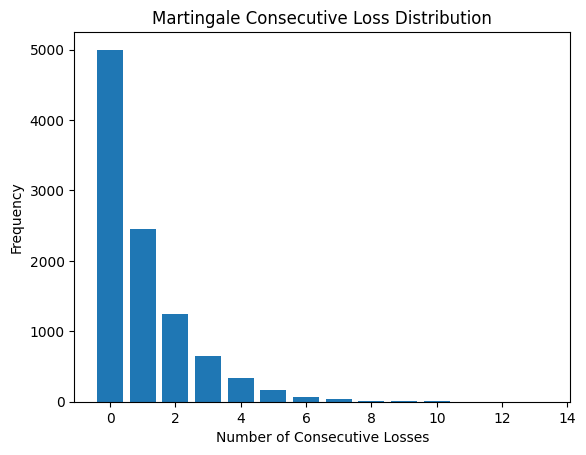

In [18]:
import random
import matplotlib.pyplot as plt

def martingale_loss_distribution(win_prob, num_rounds):
    loss_distribution = {}

    for _ in range(num_rounds):
        consecutive_losses = 0
        while True:
            # Simulate the bet outcome based on win probability
            win = random.random() < win_prob

            if win:
                break  # Exit loop if win occurs
            else:
                consecutive_losses += 1

        # Update the loss distribution
        if consecutive_losses in loss_distribution:
            loss_distribution[consecutive_losses] += 1
        else:
            loss_distribution[consecutive_losses] = 1

    return loss_distribution

# Parameters
win_prob = 0.5
num_rounds = 10000

# Calculate loss distribution
loss_distribution = martingale_loss_distribution(win_prob, num_rounds)

# Plot the distribution
plt.bar(loss_distribution.keys(), loss_distribution.values())
plt.xlabel('Number of Consecutive Losses')
plt.ylabel('Frequency')
plt.title('Martingale Consecutive Loss Distribution')
plt.show()


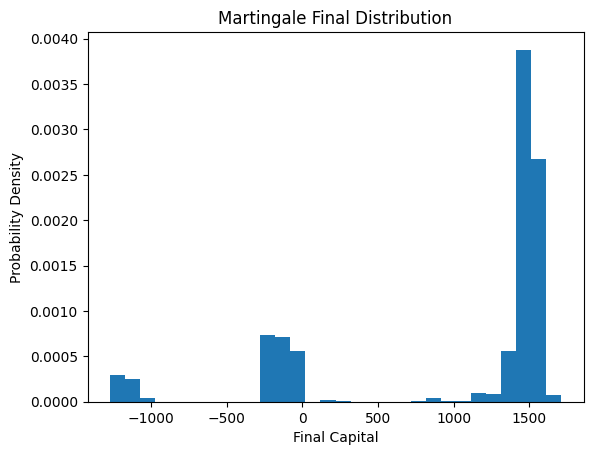

In [19]:
import random
import matplotlib.pyplot as plt

def martingale_final_distribution(initial_capital, initial_bet, win_prob, num_rounds, num_simulations):
    final_distribution = []

    for _ in range(num_simulations):
        capital = initial_capital
        bet = initial_bet

        for _ in range(num_rounds):
            # Simulate the bet outcome based on win probability
            win = random.random() < win_prob

            if win:
                capital += bet
                bet = initial_bet  # Reset bet size
            else:
                capital -= bet
                bet *= 2  # Double the bet size for the next round

            # If capital drops to zero, break the loop
            if capital <= 0:
                break

        final_distribution.append(capital)

    return final_distribution

# Parameters
initial_capital = 1000
initial_bet = 10
win_prob = 0.5
num_rounds = 100
num_simulations = 10000

# Calculate final distribution
final_distribution = martingale_final_distribution(initial_capital, initial_bet, win_prob, num_rounds, num_simulations)

# Plot the distribution
plt.hist(final_distribution, bins=30, density=True)
plt.xlabel('Final Capital')
plt.ylabel('Probability Density')
plt.title('Martingale Final Distribution')
plt.show()


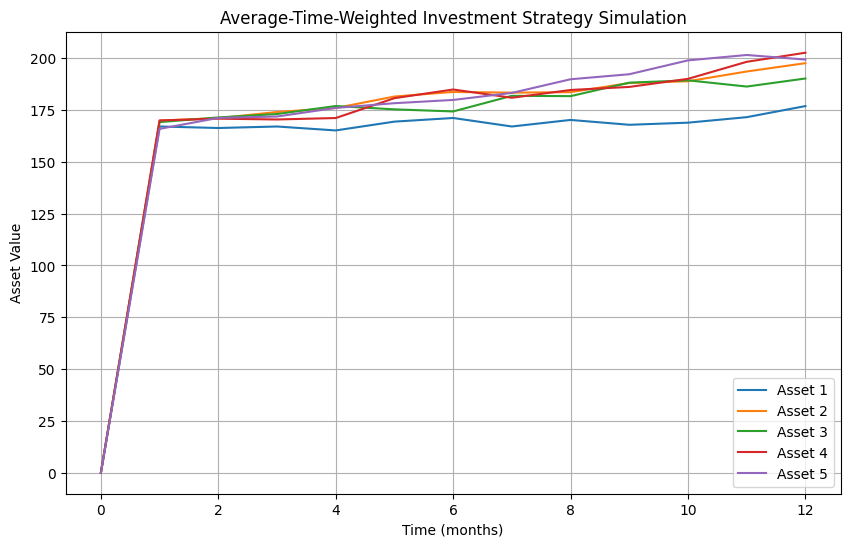

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def average_time_weighted_investment(num_assets, initial_investment, investment_interval, num_intervals, price_change_mean, price_change_std):
    # Initialize asset prices
    asset_prices = np.ones(num_assets)  # Start with a price of 1 for each asset

    # Track total value of each asset and total time each asset has been held
    asset_values = np.zeros((num_intervals + 1, num_assets))
    asset_hold_times = np.zeros(num_assets)

    for t in range(1, num_intervals + 1):
        # Simulate price changes for each asset
        price_changes = np.random.normal(price_change_mean, price_change_std, num_assets)
        asset_prices *= 1 + price_changes

        # Calculate total value of each asset
        asset_values[t] = asset_prices * (initial_investment / num_assets)

        # Update hold times for each asset
        asset_hold_times += investment_interval

    return asset_values / asset_hold_times

# Parameters
num_assets = 5
initial_investment = 10000
investment_interval = 1  # Invest every month
num_intervals = 12  # Simulate for 1 year
price_change_mean = 0.01  # Mean monthly price change (1%)
price_change_std = 0.02   # Standard deviation of monthly price change (2%)

# Simulate average-time-weighted investment strategy
asset_values = average_time_weighted_investment(num_assets, initial_investment, investment_interval, num_intervals, price_change_mean, price_change_std)

# Visualize results
plt.figure(figsize=(10, 6))
for i in range(num_assets):
    plt.plot(asset_values[:, i], label=f'Asset {i+1}')

plt.xlabel('Time (months)')
plt.ylabel('Asset Value')
plt.title('Average-Time-Weighted Investment Strategy Simulation')
plt.legend()
plt.grid(True)
plt.show()


## Buy and Hold SPXL

In [21]:
df = loader("SPXL")
spx_df = loader("SPX")
df.head()

,Date,Close
0,11/7/2008 16:00:00,3.85
1,11/14/2008 16:00:00,3.07
2,11/21/2008 16:00:00,2.22
3,11/26/2008 16:00:00,3.03
4,12/5/2008 16:00:00,2.78


In [22]:
df.shape[0]
spx_df.tail(df.shape[0]).iloc[-1]['Close']

5099.96

In [23]:
def buy_and_hold(cash_flow, ticker):
    return sum(ticker['Close'] / np.array([cash_flow]).reshape(-1))

def continiously_investment(
        df, 
        spx_df, 
        initial, 
        annual_investment, 
        weeks=None, 
        annual_risk_free_rate=0.06, 
        annual_growth_rate=0.05,
    ):
    if weeks:
        df = df.tail(weeks)
        spx_df = spx_df.tail(weeks)
    prices = df['Close'].values
    spx_price = spx_df['Close'].values
    
    cash_flow, pv, fv = generate_cash_flow(
        initial=initial, 
        annual_investment=annual_investment, 
        years=weeks/52., 
        annual_growth_rate=annual_growth_rate, 
        annual_risk_free_rate=annual_risk_free_rate, 
        mode='weekly',
    )

    share = sum(np.array([cash_flow] / df['Close'].values).reshape(-1))
    spx_share = sum(np.array([cash_flow] / spx_df['Close'].values).reshape(-1))
    security_returns = np.cumsum(df['Close'].values / np.array([cash_flow]).reshape(-1)) * df['Close'].values
    spx_returns = np.cumsum(spx_df['Close'].values / np.array([cash_flow]).reshape(-1)) * spx_df['Close'].values

    # Calculate the mean returns
    security_mean_return = np.mean(security_returns)
    spx_mean_return = np.mean(spx_returns)

    # Calculate the covariance and variance of returns
    covariance = np.cov(security_returns, spx_returns)[0, 1]
    variance_spx = np.var(spx_returns)

    # Calculate beta
    beta = covariance / variance_spx

    # Calculate alpha
    alpha = security_mean_return - (beta * spx_mean_return)

    # Calculate the excess return of the security over the risk-free rate
    # Sample weekly returns of the security and risk-free rate
    annual_security_returns =  np.array([y/x for x, y in zip(security_returns[:-52], security_returns[52:])])

    # Calculate the excess return of the security over the risk-free rate
    excess_returns = annual_security_returns - annual_risk_free_rate

    # Calculate the annualized average excess return
    annualized_excess_return = np.mean(excess_returns)  # Approximate number of weeks in a year

    # Calculate the annualized standard deviation of returns
    annualized_std_dev = np.std(annual_security_returns) # Approximate number of weeks in a year

    # Calculate the annual Sharpe Ratio
    annual_sharpe_ratio = annualized_excess_return / annualized_std_dev

    portfolio = {
        'present_value': pv,
        'future_value': fv, 
        'final_share': share,
        'final_value': security_returns[-1],
        'strategy_return':security_returns[-1] / pv, 
        'spx_return': spx_returns[-1] / pv, 
        'beta': beta, 
        'alpha': alpha,
        'annual_sharp_ratio': annual_sharpe_ratio,
        'annaul_exceeded_return': (security_returns[-1] / pv) ** (52./weeks),
    }

    logger.info(tabulate(
    [[k,v] for k, v in portfolio.items()], 
    headers=['Key', 'Value'], tablefmt='grid'))
    return


### Continually SPXL Investment

continually invest spx 30 years, annual exceeded return vs. present value of cash flow is 1.23

In [24]:
continiously_investment(
    loader("SPXL"), 
    loader("SPX"), 
    initial = 1000., 
    annual_investment=120., 
    weeks = 52 * 15,
)


INFO:lib.cash_flow_tools:{'pv': 2669.486311306871, 'fv': 6554.90777983729}
INFO:__main__:+------------------------+------------------+
| Key                    |            Value |
+========================+==================+
| present_value          |   2669.49        |
+------------------------+------------------+
| future_value           |   6554.91        |
+------------------------+------------------+
| final_share            |    548.9         |
+------------------------+------------------+
| final_value            | 946387           |
+------------------------+------------------+
| strategy_return        |    354.52        |
+------------------------+------------------+
| spx_return             |      1.04406e+06 |
+------------------------+------------------+
| beta                   |      0.000303123 |
+------------------------+------------------+
| alpha                  | -66523.3         |
+------------------------+------------------+
| annual_sharp_ratio     |      0.038

continually invest tqqq years, annual exceeded return vs. present value of cash flow is 1.27

In [25]:
continiously_investment(
    loader('TQQQ'), 
    spx_df, 
    1000., 
    5., 
    weeks = 52 * 14,
)


INFO:lib.cash_flow_tools:{'pv': 1065.2357220004683, 'fv': 2463.439849379176}
INFO:__main__:+------------------------+-------------------+
| Key                    |             Value |
+========================+===================+
| present_value          |    1065.24        |
+------------------------+-------------------+
| future_value           |    2463.44        |
+------------------------+-------------------+
| final_share            |    2157.03        |
+------------------------+-------------------+
| final_value            |       4.20017e+06 |
+------------------------+-------------------+
| strategy_return        |    3942.95        |
+------------------------+-------------------+
| spx_return             |       6.31741e+07 |
+------------------------+-------------------+
| beta                   |       5.43796e-05 |
+------------------------+-------------------+
| alpha                  | -391000           |
+------------------------+-------------------+
| annual_sharp_r

In [26]:
import matplotlib.pyplot as plt

def plot(security_returns, margin_history, share_history):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].plot(security_returns)
    # axs[0].set_yscale('log')
    axs[0].set_title("Asset History")
    axs[0].legend()
    axs[0].grid(True)
    axs[1].plot(share_history)
    axs[1].set_title("Share History")
    axs[1].legend()
    axs[1].grid(True)
    axs[2].plot(margin_history)
    axs[2].set_title("Margin History")
    axs[2].legend()
    axs[2].grid(True)
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Show the plot
    plt.show()

### buy in strategy
def keep_leverage_level(prices, cash_flow, interest_rate, leverage, max_margin=1., should_plot=False):
    margin_loan, security_returns, margin_history, share_history, share, loan = [], [], [], [], 0., 0.
    for price, cash in zip(prices, cash_flow):
        fee = loan * (interest_rate / 52.)
        asset = share * price + cash - fee - loan
        investment = leverage * asset
        loan = investment - asset
        share = investment / price
        margin_loan.append(loan)
        security_returns.append(asset)
        margin_history.append(loan / asset)
        share_history.append(share)
    if should_plot:
        plot(security_returns, margin_history, share_history)
    return margin_loan, security_returns, margin_history

def buy_with_new(prices, cash_flow, interest_rate, leverage, max_margin=1., should_plot=False):
    margin_loan, security_returns, margin_history, share_history, share, loan = [], [], [], [], 0., 0.
    for price, cash in zip(prices, cash_flow):
        fee = loan * (interest_rate / 52.)
        loan += cash * (leverage - 1.)
        share += cash * leverage / price
        share -= fee / price
        margin = loan / (share * price - loan)
        if max_margin > 1. and margin >= max_margin:
            asset = share * price - loan
            loan = asset * max_margin
            share = (asset + loan) / price
            margin = loan / (share * price - loan)
        margin_loan.append(loan)
        security_returns.append(share * price - loan)
        share_history.append(share)
        margin_history.append(margin)
    if should_plot:
        plot(security_returns, margin_history, share_history)
    return margin_loan, security_returns, margin_history

def leverage_investment(
        df, spx_df, initial, annual_investment, weeks, 
        leverage = 1., max_margin=3., annual_risk_free_rate=0.04, risk_adj=0.02, annual_inflation_rate = 0.02, 
        strategy=keep_leverage_level):

    df = df.tail(weeks)
    prices = df['Close'].values

    spx_df = spx_df.tail(weeks)
    spx_prices = spx_df['Close'].values

    cash_flow, pv, fv = generate_cash_flow(initial, annual_investment, years=weeks/52., annual_growth_rate=annual_inflation_rate, annual_risk_free_rate=annual_risk_free_rate, mode='weekly')

    margin_loan, security_returns, margin = strategy(prices, cash_flow, interest_rate=(annual_risk_free_rate + risk_adj), leverage=leverage, max_margin=max_margin, should_plot=True)
    # print(security_returns)
    spx_margin_loan, spx_returns, spx_margin = strategy(spx_prices, cash_flow, interest_rate=(annual_risk_free_rate + risk_adj), leverage=1., max_margin=max_margin, should_plot=False)
    # print("spx_returns",spx_returns)
    # print("security_returns",security_returns)
    # print("prices",prices)
    # print("spx_prices",spx_prices)

    ratio = security_returns[-1] / fv

    # Calculate the mean returns
    security_mean_return = np.mean(security_returns)
    spx_mean_return = np.mean(spx_prices)

    # Calculate the covariance and variance of returns
    covariance = np.cov(security_returns, spx_prices)[0, 1]
    variance_spx = np.var(spx_prices)

    # Calculate beta
    beta = covariance / variance_spx

    # Calculate alpha
    alpha = security_mean_return - (beta * spx_mean_return)

    # Calculate the excess return of the security over the risk-free rate
    # Sample weekly returns of the security and risk-free rate
    annual_security_returns =  np.array([y/x for x, y in zip(security_returns[:-52], security_returns[52:])])

    # Calculate the excess return of the security over the risk-free rate
    excess_returns = annual_security_returns - annual_risk_free_rate

    # Calculate the annualized average excess return
    annualized_excess_return = np.mean(excess_returns)  # Approximate number of weeks in a year

    # Calculate the annualized standard deviation of returns
    annualized_std_dev = np.std(annual_security_returns) # Approximate number of weeks in a year

    # Calculate the annual Sharpe Ratio
    annual_sharpe_ratio = annualized_excess_return / annualized_std_dev

    portfolio = {
        'present_value': pv,
        'discounted_fv': fv, 
        'final_share': security_returns[-1] / prices[-1],
        'final_value': security_returns[-1],
        'strategy_return':security_returns[-1] / pv, 
        'standard_return': spx_returns[-1] / pv, 
        'strategy/standard': security_returns[-1]/spx_returns[-1],
        'loan': margin_loan[-1],
        'margin': max(margin),
        'beta': beta, 
        'alpha': alpha,
        'annual_sharp_ratio': annual_sharpe_ratio,
        'spx_return': spx_prices[-1]/spx_prices[0],
        'annaul_exceeded_return': (security_returns[-1] / pv) ** (52./weeks),
    }
    logging.info(tabulate_printer(portfolio))
    return


Leverage SPX keep same level 2 times, annual exceeded return 1.06

INFO:lib.cash_flow_tools:{'pv': 5195.023099424564, 'fv': 17226.877922592772}


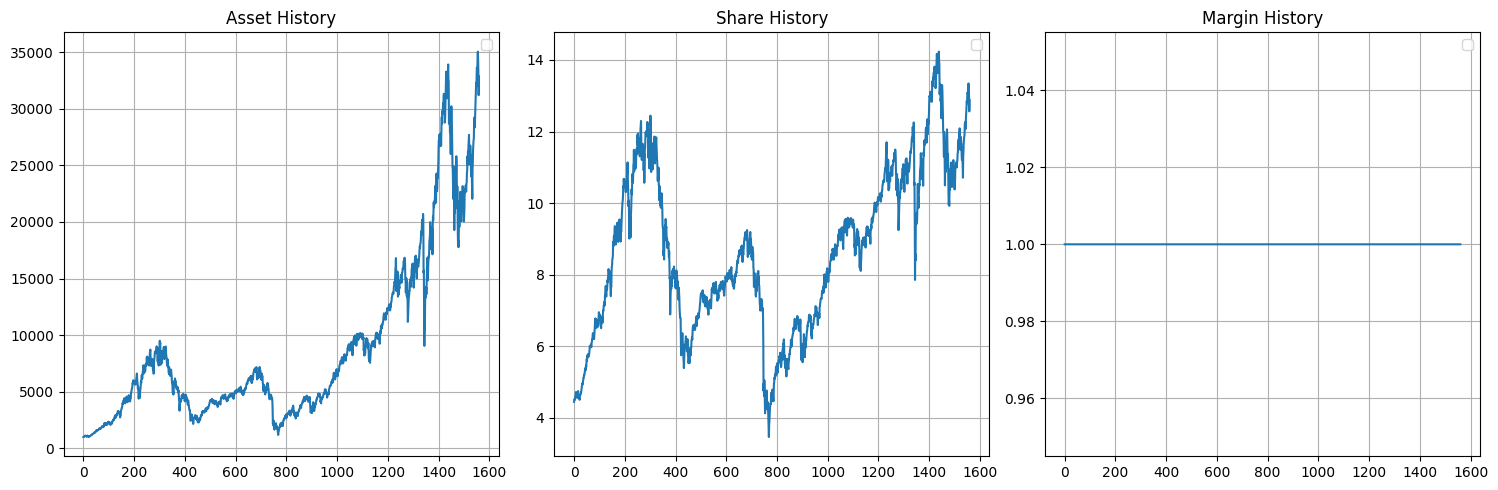

INFO:root:
+------------------------+--------------+
| Key                    |        Value |
+========================+==============+
| present_value          |  5195.02     |
+------------------------+--------------+
| discounted_fv          | 17226.9      |
+------------------------+--------------+
| final_share            |     6.44     |
+------------------------+--------------+
| final_value            | 32843.7      |
+------------------------+--------------+
| strategy_return        |     6.32216  |
+------------------------+--------------+
| standard_return        |     7.22252  |
+------------------------+--------------+
| strategy/standard      |     0.875339 |
+------------------------+--------------+
| loan                   | 32843.7      |
+------------------------+--------------+
| margin                 |     1        |
+------------------------+--------------+
| beta                   |     6.71382  |
+------------------------+--------------+
| alpha                

In [27]:
leverage_investment(
        loader('SPX'), 
        loader('SPX'),
        initial=1000., 
        annual_investment=120., 
        leverage=2., 
        max_margin=5000., 
        weeks = 52 * 30, 
        annual_risk_free_rate=0.04,
        risk_adj=0.02,
        annual_inflation_rate=0.05,
        strategy=keep_leverage_level,
        )


Leverage Nasdaq 2 times, annual exceeded return 1.086

INFO:lib.cash_flow_tools:{'pv': 5195.023099424564, 'fv': 17226.877922592772}


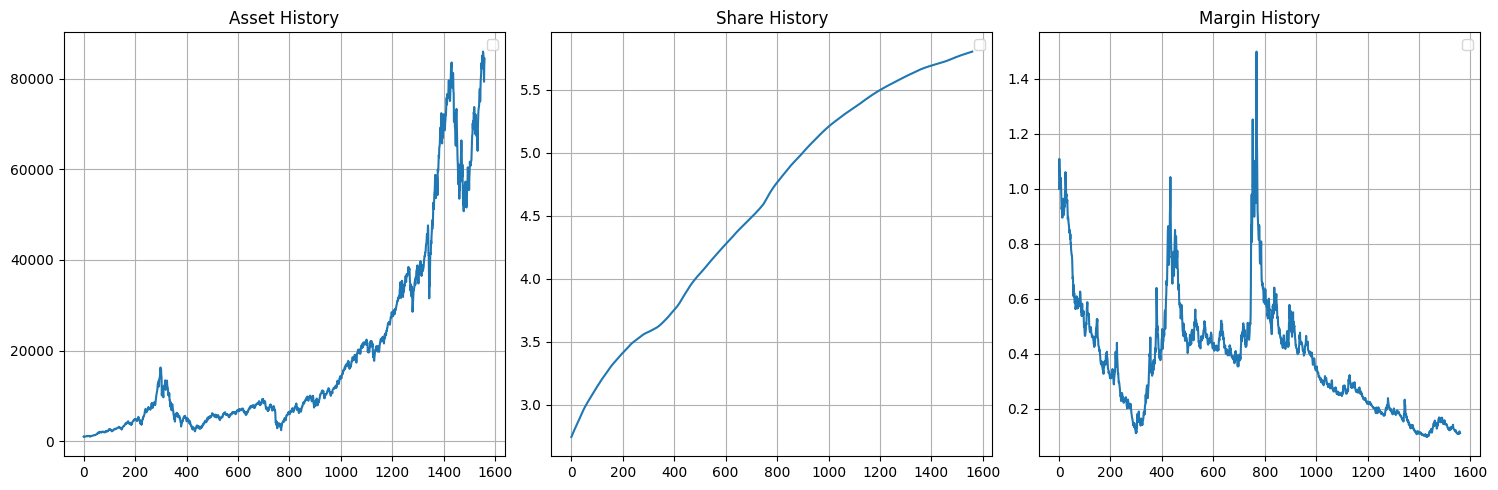

INFO:root:
+------------------------+--------------+
| Key                    |        Value |
+========================+==============+
| present_value          |   5195.02    |
+------------------------+--------------+
| discounted_fv          |  17226.9     |
+------------------------+--------------+
| final_share            |      5.22668 |
+------------------------+--------------+
| final_value            |  84444       |
+------------------------+--------------+
| strategy_return        |     16.2548  |
+------------------------+--------------+
| standard_return        |      7.22252 |
+------------------------+--------------+
| strategy/standard      |      2.25057 |
+------------------------+--------------+
| loan                   |   9346       |
+------------------------+--------------+
| margin                 |      1.49963 |
+------------------------+--------------+
| beta                   |     19.0585  |
+------------------------+--------------+
| alpha                

In [28]:
leverage_investment(
        loader('IXIC'), 
        loader('SPX'),
        initial = 1000., 
        annual_investment=120., 
        weeks = 52 * 30, 
        leverage=2., 
        max_margin=5000., 
        annual_risk_free_rate=0.04,
        risk_adj=0.02,
        annual_inflation_rate=0.05,
        strategy=buy_with_new,
        )


In [29]:
import matplotlib.pyplot as plt
import pandas as pd

def plot(security_returns, margin_history, share_history):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].plot(security_returns)
    axs[0].set_yscale('log')
    axs[0].set_title("Asset History")
    axs[0].legend()
    axs[0].grid(True)
    axs[1].plot(share_history)
    axs[1].set_title("Share History")
    axs[1].legend()
    axs[1].grid(True)
    axs[2].plot(margin_history)
    axs[2].set_title("Margin History")
    axs[2].legend()
    axs[2].grid(True)
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Show the plot
    plt.show()

### buy in strategy
def keep_leverage_level(prices, cash_flow, interest_rate, leverage, max_margin=1., should_plot=False):
    margin_loan, security_returns, margin_history, share_history, share, loan = [], [], [], [], 0., 0.
    for price, cash in zip(prices, cash_flow):
        fee = loan * (interest_rate / 52.)
        asset = share * price + cash - fee - loan
        investment = leverage * asset
        loan = investment - asset
        share = investment / price
        margin_loan.append(loan)
        security_returns.append(asset)
        margin_history.append(loan / asset)
        share_history.append(share)
    if should_plot:
        plot(security_returns, margin_history, share_history)
    return margin_loan, security_returns, margin_history

def buy_with_new(prices, cash_flow, interest_rate, leverage, max_margin=1., should_plot=False):
    margin_loan, security_returns, margin_history, share_history, share, loan = [], [], [], [], 0., 0.
    for price, cash in zip(prices, cash_flow):
        fee = loan * (interest_rate / 52.)
        loan += cash * (leverage - 1.)
        share += cash * leverage / price
        share -= fee / price
        margin = loan / (share * price - loan)
        if max_margin > 1. and margin >= max_margin:
            asset = share * price - loan
            loan = asset * max_margin
            share = (asset + loan) / price
            margin = loan / (share * price - loan)
        margin_loan.append(loan)
        security_returns.append(share * price - loan)
        share_history.append(share)
        margin_history.append(margin)
    if should_plot:
        plot(security_returns, margin_history, share_history)
    return margin_loan, security_returns, margin_history

def house_investment(
        initial, 
        annual_investment,
        years,
        leverage=5.,
        refinance_leverage=4.,
        refinance_years=5,
        house_price=1000., 
        annual_rental_income=5.*12., 
        annual_increment_rate=0.06, 
        annual_risk_free_rate=0.04, 
        risk_adj=0.02, 
        annual_inflation_rate = 0.05, 
        annual_expenditure_rate = 0.02,
    ):
    annual_loan_interest = annual_risk_free_rate + risk_adj
    df = pd.DataFrame(columns=['asset', 'loan', 'interest', 'house_unit', 'house_price', 'annual_cash_outcome'])
    cash_flow, pv, fv = generate_cash_flow(initial, annual_investment, years, annual_growth_rate=annual_inflation_rate, annual_risk_free_rate=annual_risk_free_rate)
    cash_flow = iter(cash_flow)
    initial = next(cash_flow)
    asset, house_unit, loan = initial, 0, 0
    for refinance_times in range(years // refinance_years):
        leverage = leverage if refinance_times == 0 else refinance_leverage
        house_unit = asset * leverage / house_price
        loan = asset * (leverage - 1)
        for month in range(12 * refinance_years):
            if month % 12 == 0:
                df = df._append({
                        'asset': asset, 
                        'loan': loan, 
                        'interest': loan * (annual_loan_interest),
                        'house_unit': house_unit, 
                        'house_price': house_price, 
                        'annual_cash_outcome': house_unit * annual_rental_income,
                }, ignore_index=True)
            loan += (house_unit * house_price) * (annual_expenditure_rate / 12)
            loan -= (house_unit * annual_rental_income / 12.)
            loan -= next(cash_flow)
            loan += (loan * (annual_loan_interest / 12))
            house_price += (house_price * (annual_increment_rate / 12))
            annual_rental_income *= (1. + annual_inflation_rate / 12)
            asset = house_unit * house_price - loan
    logger.info(tabulate_printer({
        "pv": pv, 
        "fv": fv,
        "initial": initial,
        "final": df.iloc[-1]['asset'],
        "annual_exceeded_return vs. pv":(df.iloc[-1]['asset'] / pv) ** (1./years),
        "annual_exceeded_return vs. initial": (df.iloc[-1]['asset'] / initial) ** (1./years),
    }))
    return df

### Idea Investment by Company in Theroy

In [30]:
house_investment(
    initial=1000.,
    annual_investment=120.,
    years=30,
    leverage=5.,
    refinance_leverage=4.,
    refinance_years=5,
    house_price=1000., 
    annual_rental_income=5.*11., 
    annual_increment_rate=0.08, 
    annual_risk_free_rate=0.05, 
    risk_adj=0.02, 
    annual_inflation_rate = 0.05, 
    annual_expenditure_rate=0.01,
)

INFO:lib.cash_flow_tools:{'pv': 4597.692307692416, 'fv': 20570.802931247727}
/var/folders/ls/5qzq87350jz6pv6jwnpg6mkm0000gn/T/ipykernel_48720/993066883.py:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append({
INFO:__main__:
+------------------------------------+--------------+
| Key                                |        Value |
+====================================+==============+
| pv                                 |   4597.69    |
+------------------------------------+--------------+
| fv                                 |  20570.8     |
+------------------------------------+--------------+
| initial                            |   1000       |
+------------------------------------+--------------+
| final                   

,asset,loan,interest,house_unit,house_price,annual_cash_outcome
0,1000.000000,4000.000000,280.000000,5.000000,1000.000000,275.000000
1,1393.128481,4021.869053,281.530834,5.000000,1082.999507,289.069522
2,1829.935936,4034.503723,282.415261,5.000000,1172.887932,303.858867
3,2314.346528,4036.838730,282.578711,5.000000,1270.237052,319.404864
4,2850.607097,4027.723406,281.940638,5.000000,1375.666100,335.746223
5,3443.312472,10329.937416,723.095619,9.244749,1489.845708,652.538100
6,4415.399448,10501.023387,735.071637,9.244749,1613.502167,685.923188
7,5493.516964,10660.961610,746.267313,9.244749,1747.422051,721.016320
8,6687.143094,10808.149235,756.570446,9.244749,1892.457220,757.904883
9,8006.533491,10940.859472,765.860163,9.244749,2049.530236,796.680735


In [31]:
house_investment(
    initial=200.,
    annual_investment=12.,
    years=10,
    leverage=5.,
    refinance_leverage=4.,
    refinance_years=5,
    house_price=1000., 
    annual_rental_income=5.*11., 
    annual_increment_rate=0.08, 
    annual_risk_free_rate=0.05, 
    risk_adj=0.02, 
    annual_inflation_rate = 0.05, 
    annual_expenditure_rate=0.01,
)

INFO:lib.cash_flow_tools:{'pv': 319.7692307692285, 'fv': 526.5773712285832}
/var/folders/ls/5qzq87350jz6pv6jwnpg6mkm0000gn/T/ipykernel_48720/993066883.py:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append({
INFO:__main__:
+------------------------------------+------------+
| Key                                |      Value |
+====================================+============+
| pv                                 |  319.769   |
+------------------------------------+------------+
| fv                                 |  526.577   |
+------------------------------------+------------+
| initial                            |  200       |
+------------------------------------+------------+
| final                              | 1548.3

,asset,loan,interest,house_unit,house_price,annual_cash_outcome
0,200.000000,800.000000,56.000000,1.000000,1000.000000,55.000000
1,275.731338,807.268169,56.508772,1.000000,1082.999507,57.813904
2,359.955663,812.932269,56.905259,1.000000,1172.887932,60.771773
3,453.439867,816.797185,57.175803,1.000000,1270.237052,63.880973
4,557.014073,818.652027,57.305642,1.000000,1375.666100,67.149245
5,671.576609,2014.729827,141.031088,1.803077,1489.845708,127.269694
6,858.256439,2051.012106,143.570847,1.803077,1613.502167,133.781053
7,1065.371792,2085.364608,145.975523,1.803077,1747.422051,140.625546
8,1294.753187,2117.492780,148.224495,1.803077,1892.457220,147.820215
9,1548.381493,2147.079207,150.295544,1.803077,2049.530236,155.382978


# 5 Years Comparison

### House Investment

14% Annual Return vs. PV

In [32]:
house_investment(
    initial=1000.,
    annual_investment=120.,
    years=10,
    leverage=5.,
    refinance_leverage=4.,
    refinance_years=5,
    house_price=1000., 
    annual_rental_income=5.*11., 
    annual_increment_rate=0.08, 
    annual_risk_free_rate=0.04, 
    risk_adj=0.02, 
    annual_inflation_rate = 0.05, 
    annual_expenditure_rate=0.01,
)

INFO:lib.cash_flow_tools:{'pv': 2259.5666195302783, 'fv': 3367.768407035602}
/var/folders/ls/5qzq87350jz6pv6jwnpg6mkm0000gn/T/ipykernel_48720/993066883.py:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append({
INFO:__main__:
+------------------------------------+------------+
| Key                                |      Value |
+====================================+============+
| pv                                 | 2259.57    |
+------------------------------------+------------+
| fv                                 | 3367.77    |
+------------------------------------+------------+
| initial                            | 1000       |
+------------------------------------+------------+
| final                              | 9047.

,asset,loan,interest,house_unit,house_price,annual_cash_outcome
0,1000.000000,4000.000000,240.000000,5.000000,1000.000000,275.000000
1,1434.135911,3980.861624,238.851697,5.000000,1082.999507,289.069522
2,1914.653761,3949.785898,236.987154,5.000000,1172.887932,303.858867
3,2445.544279,3905.640979,234.338459,5.000000,1270.237052,319.404864
4,3031.113624,3847.216878,230.833013,5.000000,1375.666100,335.746223
5,3676.007348,11028.022043,661.681323,9.869498,1489.845708,696.635832
6,4825.443779,11099.012799,665.940768,9.869498,1613.502167,732.277044
7,6096.741798,11149.436822,668.966209,9.869498,1747.422051,769.741727
8,7500.423289,11177.179650,670.630779,9.869498,1892.457220,809.123175
9,9047.846930,11179.987842,670.799271,9.869498,2049.530236,850.519452
